# 13. Sequential Data

In [5]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)

os.chdir("..")

from prml.markov import CategoricalHMM, GaussianHMM, Kalman, Particle

In [6]:
gaussian_hmm = GaussianHMM(
    initial_proba=np.ones(3) / 3,
    transition_proba=np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]),
    means=np.array([[0, 0], [2, 10], [10, 5]]),
    covs=np.asarray([np.eye(2) for _ in range(3)]))

In [9]:
seq = gaussian_hmm.draw(100)

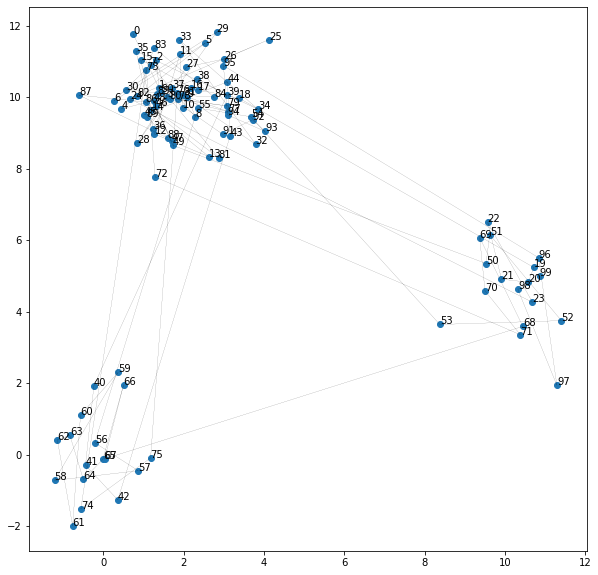

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1])
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)
plt.show()

In [11]:
posterior = gaussian_hmm.fit(seq)

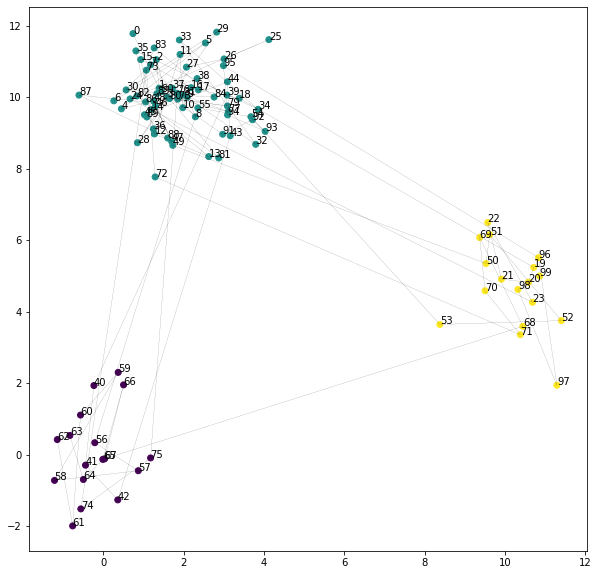

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1], c=np.argmax(posterior, axis=-1))
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)
plt.show()

In [13]:
categorical_hmm = CategoricalHMM(
    initial_proba=np.ones(2) / 2,
    transition_proba=np.array([[0.95, 0.05], [0.05, 0.95]]),
    means=np.array([[0.8, 0.2], [0.2, 0.8]]))

In [14]:
seq = categorical_hmm.draw(100)

In [15]:
posterior = categorical_hmm.forward_backward(seq)

In [16]:
hidden = categorical_hmm.viterbi(seq)

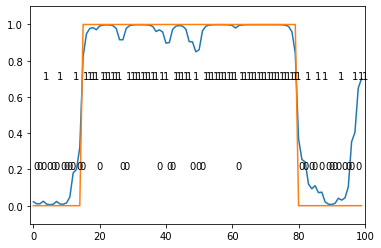

In [17]:
plt.plot(posterior[:, 1])
plt.plot(hidden)
for i in range(0, len(seq)):
    plt.annotate(str(seq[i]), (i, seq[i] / 2. + 0.2))
plt.xlim(-1, len(seq))
plt.ylim(-0.1, np.max(seq) + 0.1)
plt.show()

## 13.3 Linear Dynamical Systems

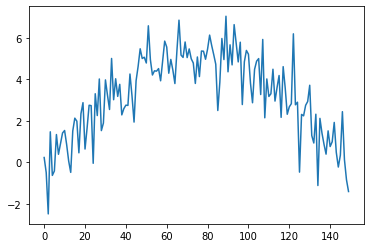

In [18]:
observed_sequence = np.concatenate(
    (np.arange(50)[:, None] * 0.1 + np.random.normal(size=(50, 1)),
     np.random.normal(loc=5., size=(50, 1)),
     5 - 0.1 * np.arange(50)[:, None] + np.random.normal(size=(50, 1))), axis=0)
plt.plot(observed_sequence)
plt.show()

In [19]:
kalman = Kalman(
    system=np.array([[1., 1.], [0., 1.]]),
    cov_system=np.eye(2) * 0.001,
    measure=np.array([[1., 0.]]),
    cov_measure=np.eye(1) * 10,
    mu0=np.zeros(2), P0=np.eye(2) * 100
)

In [20]:
mean, cov = kalman.filtering(observed_sequence)

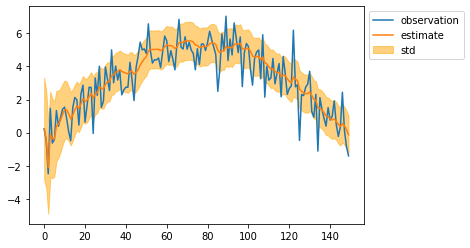

In [21]:
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

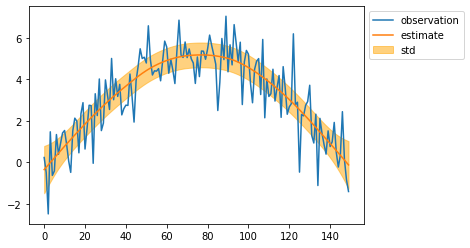

In [22]:
mean, cov = kalman.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

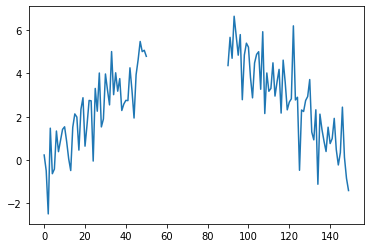

In [23]:
observed_sequence = [None if 50 < i < 90 else obs for i, obs in enumerate(observed_sequence)]
plt.plot(observed_sequence)
plt.show()

In [24]:
kalman = Kalman(
    system=np.array([[1., 1.], [0., 1.]]),
    cov_system=np.eye(2) * 0.001,
    measure=np.array([[1., 0.]]),
    cov_measure=np.eye(1) * 10,
    mu0=np.zeros(2), P0=np.eye(2) * 100
)

In [25]:
mean = []
std = []
for obs in observed_sequence:
    m, s = kalman.predict()
    if obs is not None:
        m, s = kalman.filter(obs)
    mean.append(m[0])
    std.append(np.sqrt(s[0, 0]))
mean = np.asarray(mean)
std = np.asarray(std)

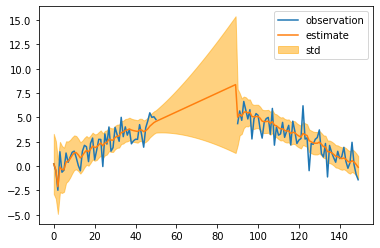

In [26]:
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

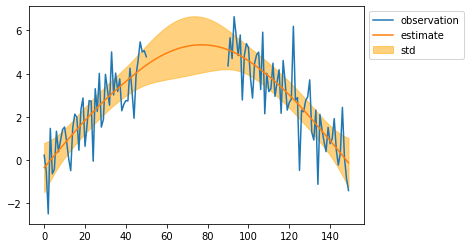

In [27]:
mean, cov = kalman.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### 13.3.4 Particle Filters

In [28]:
observed_sequence = np.concatenate(
    (np.arange(50)[:, None] * 0.1 + np.random.normal(size=(50, 1)),
     np.random.normal(loc=5., size=(50, 1)),
     5 - 0.1 * np.arange(50)[:, None] + np.random.normal(size=(50, 1))), axis=0)

In [29]:
def nll(observed, particle):
    diff = observed - particle @ np.array([1., 0.])
    return 0.1 * (diff ** 2)

particle = Particle(np.random.normal(0, 1, (1000, 2)), system=np.array([[1, 1], [0, 1]]), cov_system=np.eye(2) * 0.001, nll=nll)

In [30]:
mean, cov = particle.filtering(observed_sequence)
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])

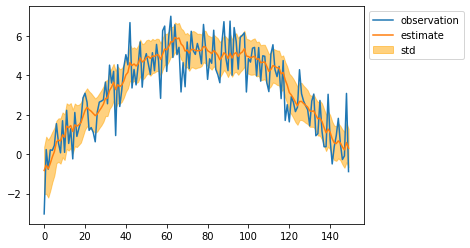

In [31]:
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

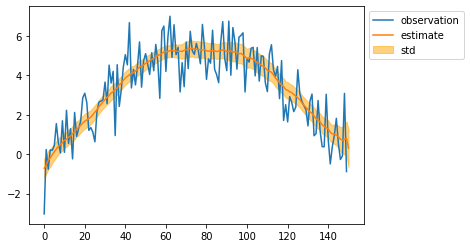

In [32]:
mean, cov = particle.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [33]:
observed_sequence = [None if 50 < i < 90 else obs for i, obs in enumerate(observed_sequence)]

In [34]:
particle = Particle(np.random.normal(0, 1, (1000, 2)), system=np.array([[1, 1], [0, 1]]), cov_system=np.eye(2) * 0.001, nll=nll)
mean = []
std = []
for obs in observed_sequence:
    p, w = particle.predict()
    if obs is not None:
        p, w = particle.filter(obs)
    mean.append(np.average(p, axis=0, weights=w)[0])
    std.append(np.cov(p, rowvar=False, aweights=w)[0, 0])
mean = np.asarray(mean)
std = np.asarray(std)

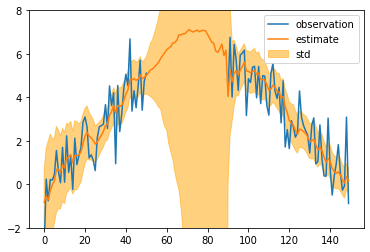

In [35]:
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.ylim(-2, 8)
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

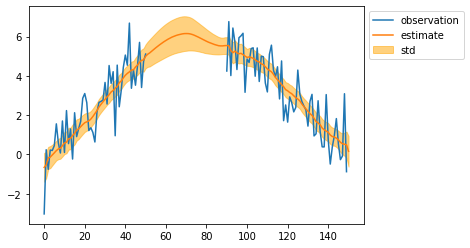

In [36]:
mean, cov = particle.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()